# Extragem doar volumul hepatic de interes, bazat pe segmentarile corecte

In [18]:
from PIL import Image
import glob
import shutil
import os
import numpy as np
import nibabel as nib
import torchvision.transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import torch
import torchvision

import seaborn as sns

from skimage import exposure
from skimage.measure import label, regionprops

In [2]:
root_dir = "G:/MachineLearning/training-batch-1/testing/"
out_dir = "G:/MachineLearning/lesion-database/testing/"
image_files = sorted(glob.glob(root_dir + 'volume*.nii'))
mask_files = sorted(glob.glob(root_dir + 'segmentation*.nii'))

In [3]:

window_min = -250
window_max = 250

downsample = torchvision.transforms.Compose(
    [torchvision.transforms.ToPILImage(),
     torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, antialias=True),
     torchvision.transforms.ToTensor()]
)
downsample_mask = torchvision.transforms.Compose(
    [torchvision.transforms.ToPILImage(),
     torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.NEAREST),
     torchvision.transforms.ToTensor()]
)

num_img = len(image_files)

for i in tqdm(range(num_img)):
    image = nib.load(image_files[i])
    image_data = image.get_fdata()


    image = nib.load(mask_files[i])
    mask_data = image.get_fdata()

    liver_mask = np.array(mask_data > 0.9, dtype=np.int8)
    image_data = np.multiply(image_data, liver_mask)
    num_slices = image_data.shape[2] # 512 x 512 x num_slices

    # print(f"Mean: {np.mean(image_data[image_data > 0].flatten())}, Std: {np.std(image_data[image_data > 0].flatten())}")

    props = regionprops(liver_mask)
    (minx, miny, minz, maxx, maxy, maxz) = props[0].bbox

    crop_size = max(maxx - minx, maxy - miny) + 10
    crop_center = (int((maxx + minx) / 2), int((maxy + miny) / 2))

    bounds = [max(crop_center[0] - int(crop_size / 2), 0),
              min(crop_center[0] + int(crop_size / 2), image_data.shape[0]),
              max(crop_center[1] - int(crop_size / 2), 0),
              min(crop_center[1] + int(crop_size / 2), image_data.shape[1])]

    for j in tqdm(range(minz, maxz)):
        # Mai intai prelucram imaginea
        slc = image_data[bounds[0]:bounds[1], bounds[2]:bounds[3], j] # Taiem doar ce ne intereseaza
        slc[slc < window_min] = window_min
        slc[slc > window_max] = window_max
        slc = (slc - window_min) / (window_max - window_min)

        # if np.max(slc.flatten()) > 0.001:
        #     mean = np.mean(slc[slc > 0].flatten())
        #     slc[slc < 0.01] = mean
        #     # p2, p98 = np.percentile(slc, (2, 98))
        #     # slc = exposure.rescale_intensity(slc, in_range=(p2, p98))
        #     slc = exposure.equalize_adapthist(slc, kernel_size=32, clip_limit=0.005)

        slc = downsample(slc.astype(np.float32)).numpy()
        slc.astype(np.float16).tofile(out_dir + "images/" + os.path.splitext(os.path.basename(image_files[i]))[0] + ("-%04d.ct" % j))

        # Acum si imaginea
        slc = mask_data[bounds[0]:bounds[1], bounds[2]:bounds[3], j] # Taiem doar ce ne intereseaza
        slc[slc < 1.5] = 0.0
        slc = downsample_mask(slc.astype(np.float32)).numpy()
        slc.astype(np.float16).tofile(out_dir + "masks/" + os.path.splitext(os.path.basename(image_files[i]))[0] + ("-%04d.ct" % j))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

C:\Users\Stanciu\anaconda3\envs\MLEnv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Text(0.5, 1.0, 'Contrast enhanced image')

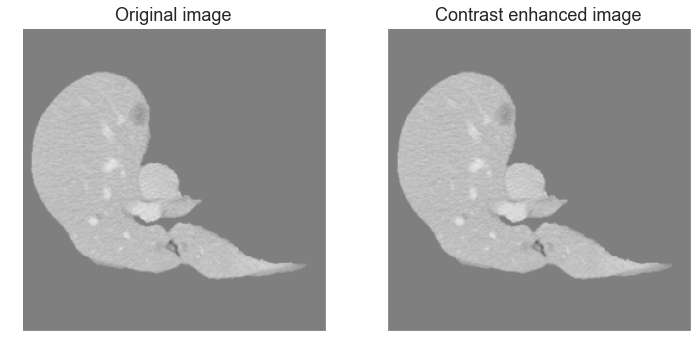

In [22]:
test_image = np.fromfile(out_dir + "images/volume-0-0058.ct", dtype=np.float16)
test_image = torch.tensor(np.squeeze(test_image).reshape((256, 256)))

orig_image = np.fromfile(out_dir + "images/orig-0-0058.ct", dtype=np.float16)
orig_image = torch.tensor(np.squeeze(test_image).reshape((256, 256)))

test_mask = np.fromfile(out_dir + "masks/volume-0-0058.ct", dtype=np.float16)
test_mask = torch.tensor(np.squeeze(test_mask).reshape((256, 256)))

img = torchvision.utils.draw_segmentation_masks((test_image*255).repeat(3, 1, 1).type(torch.uint8),
                                                (test_mask).type(torch.bool), 0.0, "red")
orig_img = torchvision.utils.draw_segmentation_masks((orig_image*255).repeat(3, 1, 1).type(torch.uint8),
                                                     (test_mask).type(torch.bool), 0.0, "red")

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(torch.permute(img, (2, 1, 0)))
ax1.set_xticks([0], [' '])
ax1.set_yticks([0], [' '])
ax1.set_title("Original image")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(torch.permute(orig_img, (2, 1, 0)))
ax2.set_xticks([0], [' '])
ax2.set_yticks([0], [' '])
ax2.set_title("Contrast enhanced image")